In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt

# Funzione: parser

Definisco una funzione che effettui il parsing del documento e che restituisca una lista contenente tutte le tuple *(misura, topic, valore). <br>
Il __parametro__ della funzione è il path al file dove è contenuta la valutazione di una run.

In [2]:
def parser(file_name):
    file = open(file_name, 'r')
    
    tuples = list()
    
    i = 0
    for line in file:
         tuples.append(line.split())
        
    return tuples

# Funzione: findTuple

La funzione riceve come __parametri__ una lista contentente tuple *(misura, topic, valore)*, una stringa attraverso la quale viene specificata quale misura si vuole prendere in considerazione e un valore booleano utilizzato come flag per selezionare il "topic" *all*. <br>
Viene ritornata una lista contenente solamente le tuple *(misura, topic, valore)* con il valore *misura* passato in input.


In [3]:
def findTuple(tuples, whatMeasure, allTopics):
    
    #measures = list()
    topics = list()
    values = list()
    
    if allTopics:
        for i in range( len(tuples) ): 
            if tuples[i][0] == whatMeasure and tuples[i][1] == "all":
                #measures.append(tuples[i][0])
                topics.append(tuples[i][1])
                values.append(float(tuples[i][2]))
    else:
        for i in range( len(tuples) ): 
            if tuples[i][0] == whatMeasure and tuples[i][1] != "all":
                #measures.append(tuples[i][0])
                topics.append(tuples[i][1])
                values.append(float(tuples[i][2]))
        
    
    return topics, values

#Potrei fare un dizionario di topic. Per ogni topic ci sono tutti le misure con i rispettivi valori

# Funzione: plotGraph
La funzione plotta le misure ottenute da ogni run per ogni topic, utilizzando degli istogrammi. <br>
I __parametri__ richiesti sono le quattro liste contenenti i valori della misura in esame ottenuti da ogni run, la lista contenente i topic e una stringa contentente il nome della misura in analisi.

In [4]:
def plotGraph(values_r1, values_r2, values_r3, values_r4, topics, measure):
    floatTop = list()
    for el in topics:
        floatTop.append(float(el))

    plt.figure(figsize=(25,15))
    plt.bar(np.subtract(floatTop, 0.3), values_r1, label='Run 1', width=0.2)
    plt.bar(np.subtract(floatTop, 0.1), values_r2, label='Run 2', width=0.2)
    plt.bar(np.subtract(floatTop, -0.1), values_r3, label='Run 3', width=0.2)
    plt.bar(np.subtract(floatTop, -0.3), values_r4, label='Run 4', width=0.2)
    plt.xlabel('Topics')
    plt.xlim(350,401)
    plt.ylabel(measure)
    plt.title(measure)
    plt.legend()
    plt.show()

# Funzione: computeANOVA
La funzione effettua il test statistico ANOVA e stampa i valori delle medie. <br>
Viene ritornato un DataFrame che permette di stampare la tabella riassuntiva con i valori calcolati durante il test. <br>
I 4 __parametri__ richiesti sono le liste contenenti i valori ottenuti dalle run per ogni topic.

In [5]:
def computeANOVA(values_r1, values_r2, values_r3, values_r4):
    #number of row
    p = len(values_r1) #i vettori di ogni run contengono tutti lo stesso numero di elementi

    #number of column
    q = 4

    grand_mean = (np.sum(values_r1) + np.sum(values_r2) + np.sum(values_r3) + np.sum(values_r4))/(p*q)
    print("Grand mean: " + str(grand_mean) + "\n")
    
    marginal_mean1 = (np.sum(values_r1))/p
    print("Marginal mean1: " + str(marginal_mean1))

    marginal_mean2 = (np.sum(values_r2))/p
    print("Marginal mean2: " + str(marginal_mean2))

    marginal_mean3 = (np.sum(values_r3))/p
    print("Marginal mean3: " + str(marginal_mean3))

    marginal_mean4 = (np.sum(values_r4))/p
    print("Marginal mean4: " + str(marginal_mean4) + "\n")

    sq_val = 0
    for i in range(len(ap_values_run1)):
        sq_val += values_r1[i]**2 
        sq_val += values_r2[i]**2
        sq_val += values_r3[i]**2
        sq_val += values_r4[i]**2 

    ss_total = sq_val - ((np.sum(values_r1)+np.sum(values_r2)+np.sum(values_r3)+np.sum(values_r4))**2)/(p*q)
    df_total = p*q - 1

    ss_col = np.sum(values_r1)**2/p+np.sum(values_r2)**2/p+np.sum(values_r3)**2/p+np.sum(values_r4)**2/p - ((np.sum(values_r1)+np.sum(values_r2)+np.sum(values_r3)+np.sum(values_r4))**2)/(p*q)
    df_col = q - 1
    ms_col = ss_col / df_col

    ss_error = ss_total - ss_col
    df_error = q*(p-1)
    ms_error = ss_error / df_error
    
    #Preparo la tabella contenente i risultati di ANOVA
    columns = list()
    columns.append('SS')
    columns.append('DF')
    columns.append('MS')
    columns.append('F')
    columns.append('Prob>F')


    rows = list()
    rows.append('Columns')
    rows.append('Error')
    rows.append('Total')

    df = pd.DataFrame(np.zeros, index=rows, columns=columns)
    
    f_stat = ms_col / ms_error 

    p_value = stats.f.sf(f_stat, df_col, df_error)
    
    df.iloc[0, 0] = ss_col
    df.iloc[0, 1] = df_col
    df.iloc[0, 2] = ms_col
    df.iloc[0, 3] = f_stat
    df.iloc[0, 4] = p_value
    df.iloc[1, 0] = ss_error
    df.iloc[1, 1] = df_error
    df.iloc[1, 2] = ms_error
    df.iloc[2, 0] = ss_total
    df.iloc[2, 1] = df_total
    
    return df

# Funzione: bestRun
La funzione confronta le medie della misura in esame e restituisce una stringa contenente la run più performante. <br>
I __parametri__ passati alla funzione sono le quattro medie della misura in esame, cioè il valore della misura nel topic *all*.

In [6]:
def bestRun(all1, all2, all3, all4):
    bestRun = ''
    bestVal = max(all1, all2, all3, all4)
    if bestVal == all1:
        bestRun = 'Run1'
    elif bestVal == all2:
        bestRun = 'Run2'
    elif bestVal == all3:
        bestRun = 'Run3'
    else:
        bestRun = 'Run4'
    
    return bestRun

# Funzione: tukeysTest
La funzione, che ha riceve come __parametri__ i valori delle misure ottenuti in ogni run che si vuole confrontare, le run a cui appartengono i valori e il nome delle misure sull'asse x, esegue il *test di Tukey*. Vengono poi stampati i risultati ottenuti dai confronti a coppie delle varie run e viene plottato il grafico.

In [7]:
def tukeysTest(values_r1, values_r2, values_r3, values_r4, bestRun, groups, xlabel):
    allValues = np.concatenate([values_r1, values_r2, values_r3, values_r4])
    mc = MultiComparison(allValues, groups)
    result = mc.tukeyhsd()
    print(xlabel)
    print(result)
        
    result.plot_simultaneous(comparison_name=bestRun,xlabel=xlabel,ylabel="RUN")

# Estrazione delle tuple

In [8]:
tuples_run1 = parser("/Users/marco/Documents/Universita/Information_Retrieval/terrier-core-4.4/var/Valutazioni/BM25_Stopwords_Stemmer.txt")
tuples_run2 = parser("/Users/marco/Documents/Universita/Information_Retrieval/terrier-core-4.4/var/Valutazioni/TF_IDF_Stopwords_Stemmer.txt")
tuples_run3 = parser("/Users/marco/Documents/Universita/Information_Retrieval/terrier-core-4.4/var/Valutazioni/BM25_Stemmer.txt")
tuples_run4 = parser("/Users/marco/Documents/Universita/Information_Retrieval/terrier-core-4.4/var/Valutazioni/TF_IDF_Simple.txt")

# Precision_Recall Curve

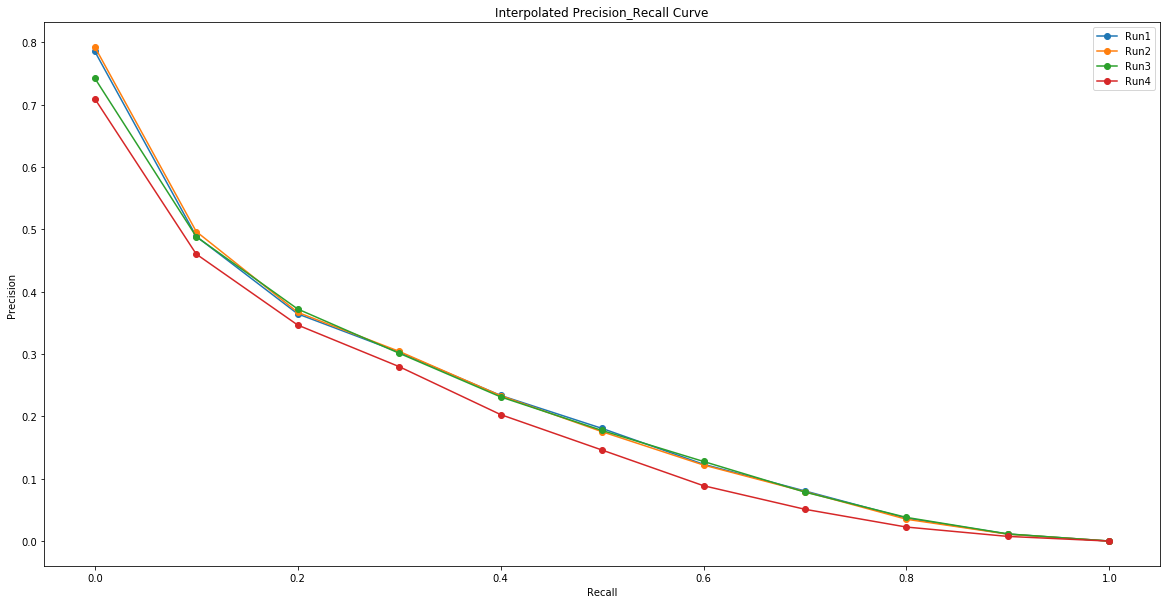

In [9]:
interp_p_r_1 = list()
interp_p_r_2 = list()
interp_p_r_3 = list()
interp_p_r_4 = list()
recall = list()

for i in range(11):
    measure = 'iprec_at_recall_' 
    r = '' + str(i*0.10) + '0'
    rec = r[:4]
    measure += rec
    
    topics, i_p_r_1 = findTuple(tuples_run1, measure, True)
    topics, i_p_r_2 = findTuple(tuples_run2, measure, True)
    topics, i_p_r_3 = findTuple(tuples_run3, measure, True)
    topics, i_p_r_4 = findTuple(tuples_run4, measure, True)
    
    interp_p_r_1.append(i_p_r_1)
    interp_p_r_2.append(i_p_r_2)
    interp_p_r_3.append(i_p_r_3)
    interp_p_r_4.append(i_p_r_4)
    recall.append(float(rec))
    
    
plt.figure(figsize=(20,10))
plt.plot(recall, interp_p_r_1, marker='o', label='Run1')
plt.plot(recall, interp_p_r_2, marker='o', label='Run2')
plt.plot(recall, interp_p_r_3, marker='o', label='Run3')
plt.plot(recall, interp_p_r_4, marker='o', label='Run4')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Interpolated Precision_Recall Curve')
plt.legend()
plt.show()

# AP e MAP


#### Memorizzazione dei valori AP per ogni topic e della MAP ottenuti in ogni run effettuata

In [10]:
topics, ap_values_run1 = findTuple(tuples_run1, "map", False)
topics_all, map_run1 = findTuple(tuples_run1, "map", True)

topics, ap_values_run2 = findTuple(tuples_run2, "map", False)
topics_all, map_run2 = findTuple(tuples_run2, "map", True)

topics, ap_values_run3 = findTuple(tuples_run3, "map", False)
topics_all, map_run3 = findTuple(tuples_run3, "map", True)

topics, ap_values_run4 = findTuple(tuples_run4, "map", False)
topics_all, map_run4 = findTuple(tuples_run4, "map", True)   

#### Plot delle AP e della MAP

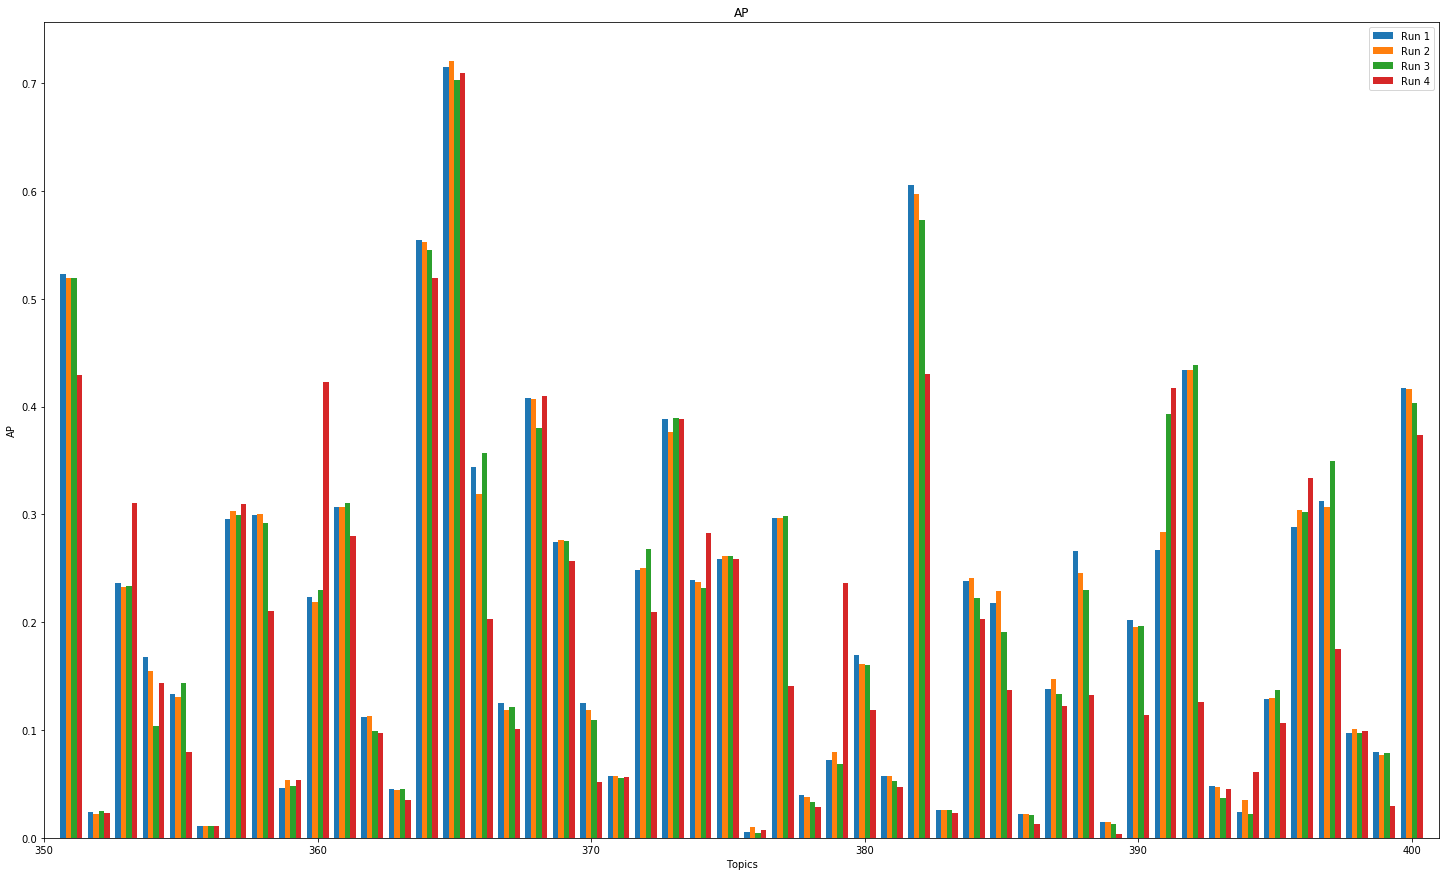

In [12]:
plotGraph(ap_values_run1, ap_values_run2, ap_values_run3, ap_values_run4, topics, 'AP')

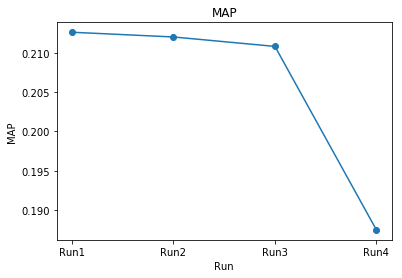

In [13]:
plt.figure()
plt.plot(['Run1', 'Run2', 'Run3', 'Run4'], [map_run1,map_run2,map_run3,map_run4], marker='o')
plt.xlabel('Run')
plt.ylabel('MAP')
plt.title('MAP')
plt.show()

#### ANOVA sui valori AP

In [14]:
dataFrame_ap = computeANOVA(ap_values_run1,ap_values_run2,ap_values_run3,ap_values_run4)
dataFrame_ap.style

Grand mean: 0.205731

Marginal mean1: 0.212576
Marginal mean2: 0.212044
Marginal mean3: 0.210822
Marginal mean4: 0.187482



#### Test di Tukey su AP

AP
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Run1   Run2  -0.0005  -0.0865 0.0855 False 
 Run1   Run3  -0.0018  -0.0877 0.0842 False 
 Run1   Run4  -0.0251  -0.1111 0.0609 False 
 Run2   Run3  -0.0012  -0.0872 0.0848 False 
 Run2   Run4  -0.0246  -0.1106 0.0614 False 
 Run3   Run4  -0.0233  -0.1093 0.0626 False 
--------------------------------------------


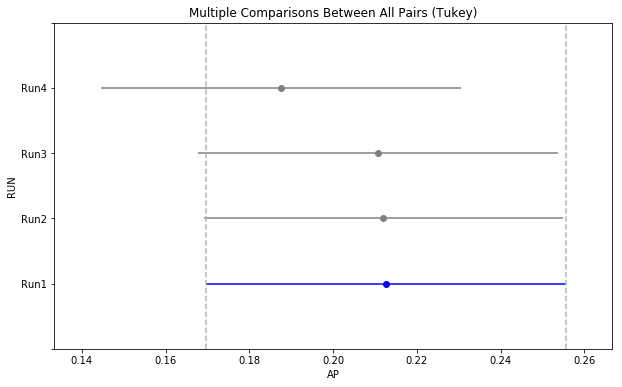

In [15]:
groups = list()
for i in range(4):
    for j in range(50):
        groups.append("Run"+str(i+1))
# La lista groups è uguale per ogni misura, quindi non verrà più ricalcolata

bestRunMAP = bestRun(map_run1, map_run2, map_run3, map_run4)

tukeysTest(ap_values_run1, ap_values_run2, ap_values_run3, ap_values_run4, bestRunMAP, groups, "AP")

# Rprec

#### Memorizzazione dei valori Rprec per ogni topic e del valore medio su tutti i topic ottenuti in ogni run effettuata

In [16]:
topics, rprec_values_run1 = findTuple(tuples_run1, "Rprec", False)
topics_all, rprec_all_run1 = findTuple(tuples_run1, "Rprec", True)
    
topics, rprec_values_run2 = findTuple(tuples_run2, "Rprec", False)
topics_all, rprec_all_run2 = findTuple(tuples_run2, "Rprec", True)
    
topics, rprec_values_run3 = findTuple(tuples_run3, "Rprec", False)
topics_all, rprec_all_run3 = findTuple(tuples_run3, "Rprec", True)
    
topics, rprec_values_run4 = findTuple(tuples_run4, "Rprec", False)
topics_all, rprec_all_run4 = findTuple(tuples_run4, "Rprec", True)

#### Plot dei valori Rprec e del valore medio su tutti i topic

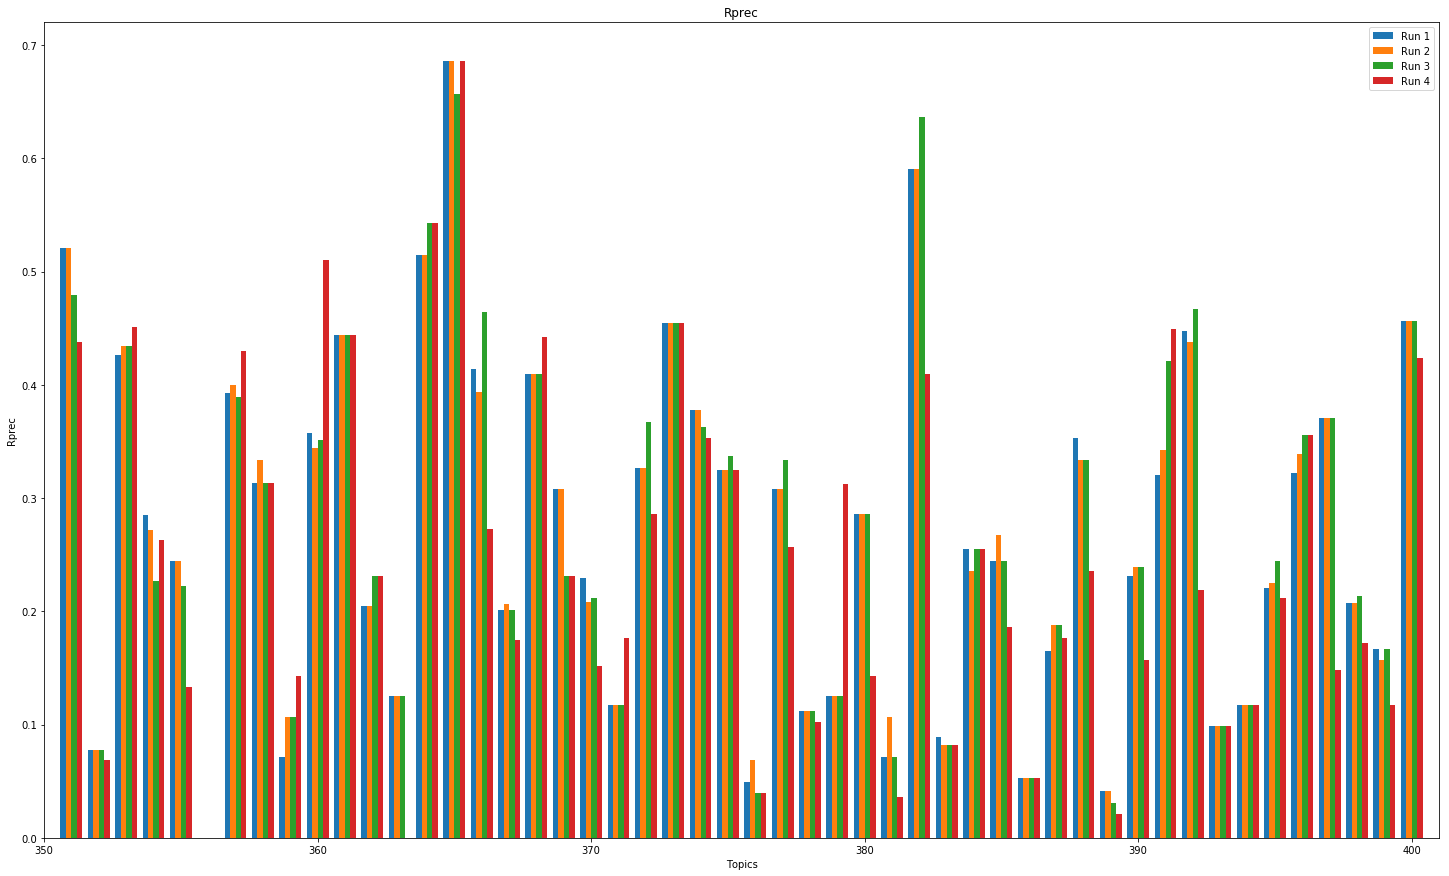

In [17]:
plotGraph(rprec_values_run1, rprec_values_run2, rprec_values_run3, rprec_values_run4, topics, 'Rprec')

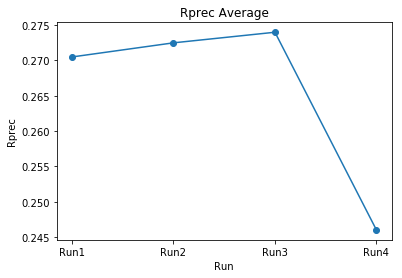

In [18]:
plt.figure()
plt.plot(['Run1', 'Run2', 'Run3', 'Run4'], [rprec_all_run1, rprec_all_run2, rprec_all_run3, rprec_all_run4], marker='o')
plt.xlabel('Run')
plt.ylabel('Rprec')
plt.title('Rprec Average')
plt.show()

#### ANOVA sui valori di Rprec

In [19]:
dataFrame_rprec = computeANOVA(rprec_values_run1, rprec_values_run2, rprec_values_run3, rprec_values_run4)
dataFrame_rprec.style

Grand mean: 0.265718

Marginal mean1: 0.270522
Marginal mean2: 0.27245
Marginal mean3: 0.273952
Marginal mean4: 0.245948



#### Test di Tukey su Rprec

Rprec
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Run1   Run2   0.0019  -0.0801 0.0839 False 
 Run1   Run3   0.0034  -0.0786 0.0854 False 
 Run1   Run4  -0.0246  -0.1066 0.0574 False 
 Run2   Run3   0.0015  -0.0805 0.0835 False 
 Run2   Run4  -0.0265  -0.1085 0.0555 False 
 Run3   Run4   -0.028   -0.11  0.054  False 
--------------------------------------------


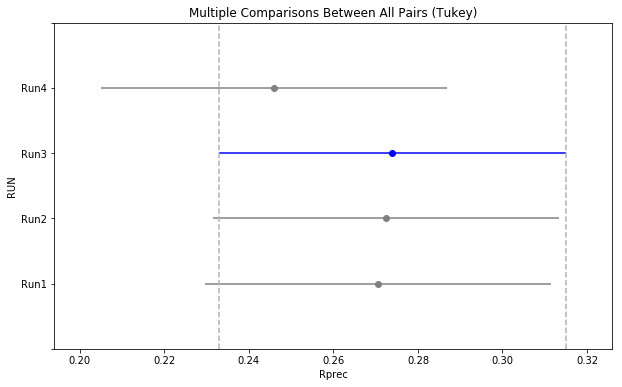

In [20]:
bestRunRprec = bestRun(rprec_all_run1, rprec_all_run2, rprec_all_run3, rprec_all_run4)

tukeysTest(rprec_values_run1, rprec_values_run2, rprec_values_run3, rprec_values_run4, bestRunRprec, groups, "Rprec")

# Precision at 10

#### Memorizzazione dei valori P@10 per ogni topic e del valore medio su tutti i topic ottenuti in ogni run effettuata

In [21]:
topics, p10_values_run1 = findTuple(tuples_run1, "P_10", False)
topics_all, p10_all_run1 = findTuple(tuples_run1, "P_10", True)

topics, p10_values_run2 = findTuple(tuples_run2, "P_10", False)
topics_all, p10_all_run2 = findTuple(tuples_run2, "P_10", True)
   
topics, p10_values_run3 = findTuple(tuples_run3, "P_10", False)
topics_all, p10_all_run3 = findTuple(tuples_run3, "P_10", True)
   
topics, p10_values_run4 = findTuple(tuples_run4, "P_10", False)
topics_all, p10_all_run4 = findTuple(tuples_run4, "P_10", True)

#### Plot dei valori P@10 e del valore medio su tutti i topic

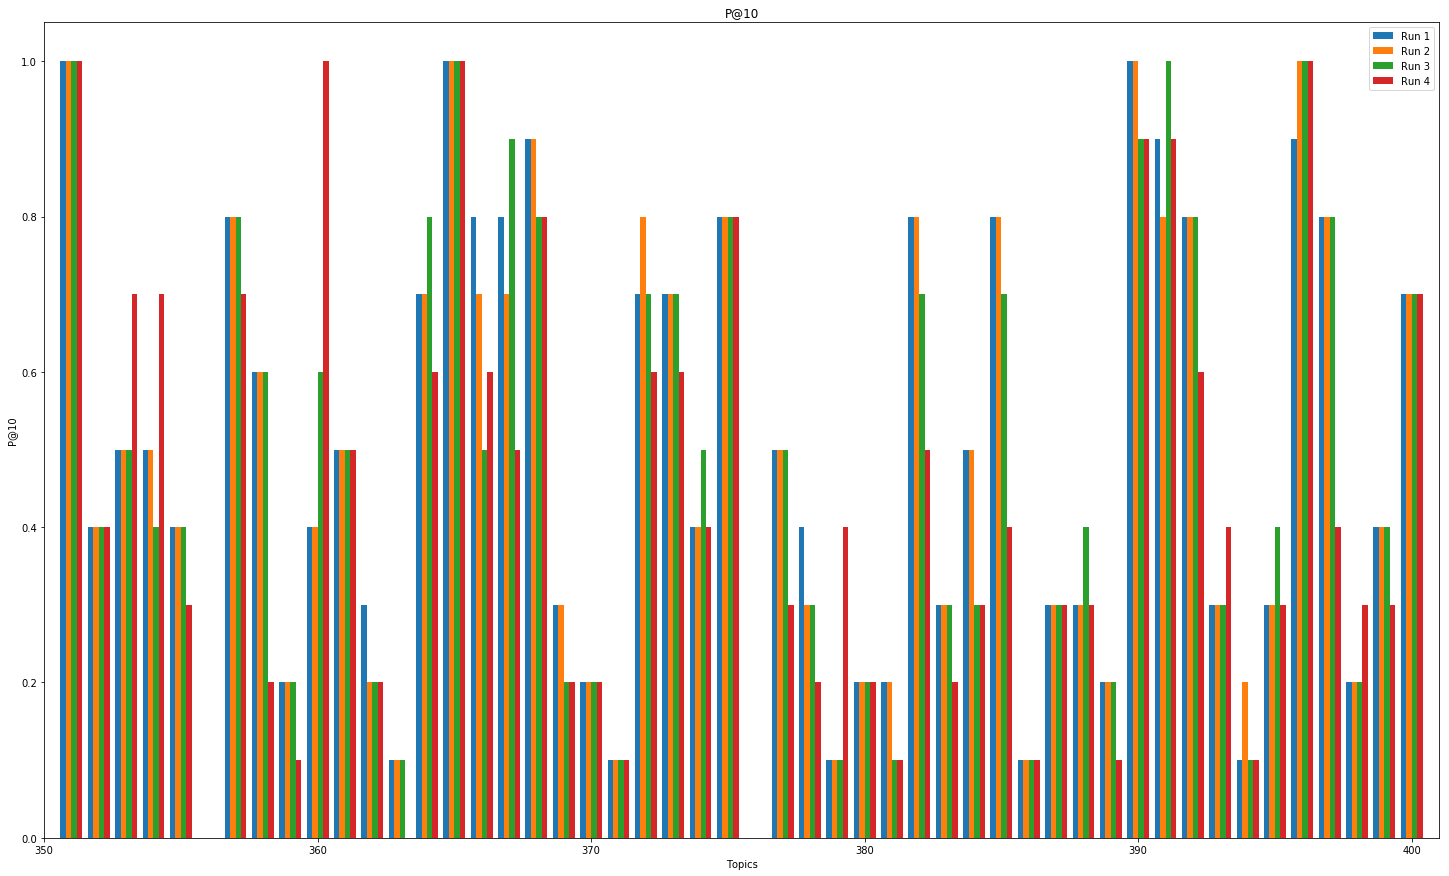

In [22]:
plotGraph(p10_values_run1, p10_values_run2, p10_values_run3, p10_values_run4, topics, 'P@10')

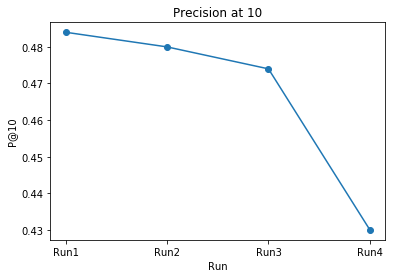

In [23]:
plt.figure()
plt.plot(['Run1', 'Run2', 'Run3', 'Run4'], [p10_all_run1, p10_all_run2, p10_all_run3, p10_all_run4], marker='o')
plt.xlabel('Run')
plt.ylabel('P@10')
plt.title('Precision at 10')
plt.show()

#### ANOVA sui valori di P@10

In [24]:
dataFrame_p10 = computeANOVA(p10_values_run1, p10_values_run2, p10_values_run3, p10_values_run4)
dataFrame_p10.style

Grand mean: 0.46699999999999997

Marginal mean1: 0.484
Marginal mean2: 0.4799999999999999
Marginal mean3: 0.474
Marginal mean4: 0.43



#### Test di Tukey su Rprec

P@10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Run1   Run2   -0.004  -0.1572 0.1492 False 
 Run1   Run3   -0.01   -0.1632 0.1432 False 
 Run1   Run4   -0.054  -0.2072 0.0992 False 
 Run2   Run3   -0.006  -0.1592 0.1472 False 
 Run2   Run4   -0.05   -0.2032 0.1032 False 
 Run3   Run4   -0.044  -0.1972 0.1092 False 
--------------------------------------------


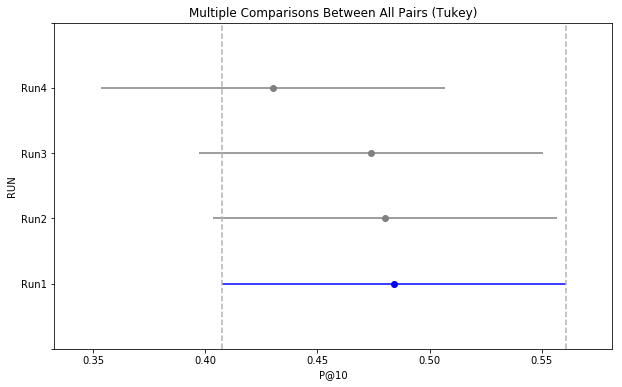

In [25]:
bestRunP10 = bestRun(p10_all_run1, p10_all_run2, p10_all_run3, p10_all_run4)

tukeysTest(p10_values_run1, p10_values_run2, p10_values_run3, p10_values_run4, bestRunP10, groups, "P@10")